# Data Exploration

This notebook is used as the playground to explore the data we are provided and to implement and test the main functions which will be further used in the assignment. As a result, this is a playground, which further evolves into the file `preprocess_dataset.py`

In [100]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [101]:
paranmt = pd.read_csv(
    "../data/raw/filtered_paranmt/filtered.tsv", sep="\t", index_col=0
)
paranmt.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


In [102]:
paranmt.iloc[19][["reference", "translation"]]

reference      Murder for hire.
translation    murder to order.
Name: 19, dtype: object

In [103]:
paranmt.iloc[7][["reference", "translation"]]

reference      Maine was very short on black people back then.
translation             there wasn't much black in Maine then.
Name: 7, dtype: object

In [104]:
paranmt.iloc[62][["reference", "translation"]]

reference      Mikael was braver, or more foolhardy!
translation            Mikael was bolder, or bolder.
Name: 62, dtype: object

As we can see, most of the data rows are quite strange and not representative at all. We can try to increase sanity of the results by adding thresholds on the toxicity. (also issues of the dataset addressed in the original paper and in the first report document)

For instance, we can widen the gap between the toxic and non-toxic examples by adding thresholds on both toxicity parameters.

$$ref_{tox} > 0.99, trn_{tox} < 0.01 \vee ref_{tox} < 0.01, trn_{tox} > 90$$

These boders might seem quite strict, as we request high level of confidence in toxicity and non-toxicity, however, as will be shown further, this leaves us with as much as 170k of rows.

In [105]:
filtered = paranmt[
    ((paranmt["ref_tox"] > 0.99) & (paranmt["trn_tox"] < 0.01))
    | ((paranmt["trn_tox"] > 0.99) & (paranmt["ref_tox"] < 0.01))
]

In [106]:
filtered.shape

(173907, 6)

In [107]:
filtered.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348
6,"They're all laughing at us, so we'll kick your...",they're laughing at us. We'll show you.,0.618866,0.230769,0.999492,0.000131
13,"Come on, Cal, leave that shit alone.","come on, Cal, put it down.",0.660481,0.270270,0.999637,0.000279
14,So he's the Top dog.,he's the tallest son of a bitch.,0.611092,0.363636,0.000920,0.999639
22,"Real life starts the first time you fuck, kid.","boy, real life starts up first.",0.866697,0.319149,0.998222,0.000114


As soon as we have (kind of) reliable data source, we can preprocess it before feeding into any of the algorithms.

In [108]:
preprocessed = filtered[["reference", "translation"]].copy()

In [109]:
import re


def preprocess(text):
    fix = text
    fix = re.sub(r"\s+", " ", fix)
    fix = re.sub(r"\d+", "", fix)
    fix = re.sub(r"([.!?])", r" ", fix)
    fix = re.sub(r"[^a-zA-Z.!?]+", r" ", fix)
    fix = fix.strip()
    fix = fix.lower()

    return fix

In [110]:
cringe_str = "  tHIS is a goo33d text with!!!\@\"'`: some INTERESTING stuff here     "

In [111]:
preprocessed_cringe = preprocess(cringe_str)
preprocessed_cringe

'this is a good text with some interesting stuff here'

In [112]:
preprocessed["reference"] = preprocessed["reference"].map(lambda x: preprocess(x))
preprocessed["translation"] = preprocessed["translation"].map(lambda x: preprocess(x))
preprocessed.head()

,reference,translation
4,i ve got orders to put her down,i have orders to kill her
6,they re all laughing at us so we ll kick your ass,they re laughing at us we ll show you
13,come on cal leave that shit alone,come on cal put it down
14,so he s the top dog,he s the tallest son of a bitch
22,real life starts the first time you fuck kid,boy real life starts up first


In [113]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")


def semantic_preprocess(text):
    fix = text
    fix = word_tokenize(fix)
    fix = [word for word in fix if word not in stopwords.words("english")]
    fix = [WordNetLemmatizer().lemmatize(word) for word in fix]
    return fix

[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/vscode/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [114]:
not_cringe = semantic_preprocess(preprocessed_cringe)
not_cringe

['good', 'text', 'interesting', 'stuff']

In [116]:
mask = filtered["trn_tox"] > filtered["ref_tox"]
temp = preprocessed.loc[mask, "reference"].copy()
preprocessed.loc[mask, "reference"] = preprocessed.loc[mask, "translation"]
preprocessed.loc[mask, "translation"] = temp

new_df = pd.DataFrame()
new_df["t1"] = preprocessed["reference"]
new_df["t2"] = preprocessed["translation"]

new_df["t1"] = new_df["t1"].apply(preprocess).apply(semantic_preprocess)
new_df["t2"] = new_df["t2"].apply(preprocess).apply(semantic_preprocess)

In [117]:
new_df

,t1,t2
4,"[order, kill]","[got, order, put]"
6,"[laughing, u, kick, as]","[laughing, u, show]"
13,"[come, cal, leave, shit, alone]","[come, cal, put]"
14,"[tallest, son, bitch]","[top, dog]"
22,"[real, life, start, first, time, fuck, kid]","[boy, real, life, start, first]"
...,...,...
577752,"[shit, happened]",[happened]
577753,"[sometimes, girl, stop, nice, get, shit]","[domino, sometimes, girl, naughty, get, jam]"
577764,"[execute, chief]","[carry, chief]"
577775,"[called, fucking, hero, truth, care, anymore]","[said, hero, care]"


In [118]:
bad_text = " ".join([token for tokens in new_df["t1"] for token in tokens])
bad_text[:100]

'order kill laughing u kick as come cal leave shit alone tallest son bitch real life start first time'

In [119]:
good_text = " ".join([token for tokens in new_df["t2"] for token in tokens])
good_text[:100]

'got order put laughing u show come cal put top dog boy real life start first gosh even pronounce lov'

In [120]:
bad_wordcloud = WordCloud(
    max_font_size=40, background_color="white", margin=0, width=300, height=300
).generate(bad_text)
good_wordcloud = WordCloud(
    max_font_size=40, background_color="white", margin=0, width=300, height=300
).generate(good_text)

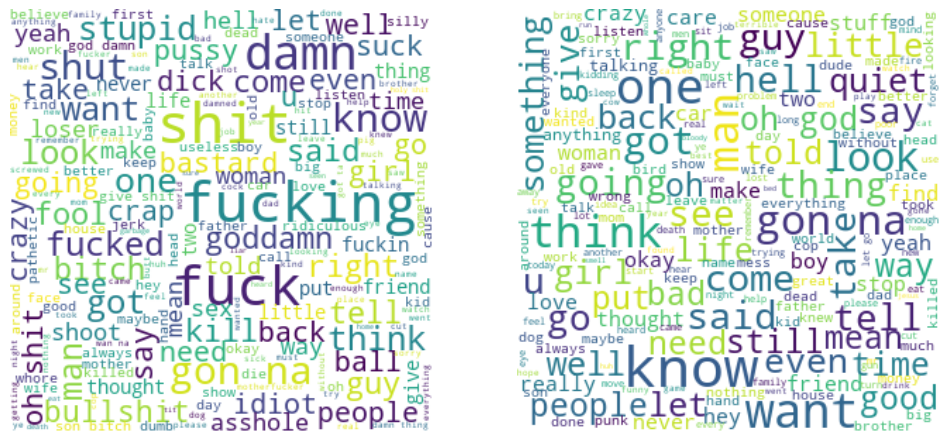

In [121]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(bad_wordcloud, interpolation="bilinear")
ax1.axis("off")
ax2.imshow(good_wordcloud, interpolation="bilinear")
ax2.axis("off")
plt.show()

## What is it and why do we actually need it?
These clouds show a great picture of overall frequency of the words in the text samples. What is even more important, we can see that the clean data actually have zero to none bad words, while the toxic data have them pretty frequently. We can use this as the main points of model's training. For instance, it will have quite good understanding which tokens (toxic ones) are quite often replaced with the non-toxic analogues. This (not so credible) [source](https://chat-gpt-5.ai/gpt-fine-tuning/) suggests to minimize the prompt and response length by providing only the examples of replacements in the consistent format.

In [122]:
def remove_common_tokens(row):
    t1 = row["t1"]
    t2 = row["t2"]
    new_t1 = [token for token in t1 if token not in t2]
    new_t2 = [token for token in t2 if token not in t1]
    return new_t1, new_t2

In [123]:
new_df["t1_new"], new_df["t2_new"] = zip(*new_df.apply(remove_common_tokens, axis=1))
new_df.head()

,t1,t2,t1_new,t2_new
4,"[order, kill]","[got, order, put]",[kill],"[got, put]"
6,"[laughing, u, kick, as]","[laughing, u, show]","[kick, as]",[show]
13,"[come, cal, leave, shit, alone]","[come, cal, put]","[leave, shit, alone]",[put]
14,"[tallest, son, bitch]","[top, dog]","[tallest, son, bitch]","[top, dog]"
22,"[real, life, start, first, time, fuck, kid]","[boy, real, life, start, first]","[time, fuck, kid]",[boy]


This way we utilize the assumption of optimization of learning time and showing more distinctively which tokens and how we should replace in order to learn the skill of getting rid of toxicity.

Very good example of this approach is the line ID 6:

In [124]:
new_df.loc[6], filtered.loc[6]

(t1        [laughing, u, kick, as]
 t2            [laughing, u, show]
 t1_new                 [kick, as]
 t2_new                     [show]
 Name: 6, dtype: object,
 reference      They're all laughing at us, so we'll kick your...
 translation              they're laughing at us. We'll show you.
 similarity                                              0.618866
 lenght_diff                                             0.230769
 ref_tox                                                 0.999492
 trn_tox                                                 0.000131
 Name: 6, dtype: object)

After the filtering we might need a new cloud:

In [125]:
bad_text = " ".join([token for tokens in new_df["t1_new"] for token in tokens])
bad_text[:100]

'kill kick as leave shit alone tallest son bitch time fuck kid shit one like shit hey bastard got gri'

In [126]:
good_text = " ".join([token for tokens in new_df["t2_new"] for token in tokens])
good_text[:100]

'got put show put top dog boy gosh love man cut bill go say done mutt quiet upset stood little oh god'

In [127]:
bad_wordcloud = WordCloud(
    max_font_size=40, background_color="white", margin=0, width=300, height=300
).generate(bad_text)
good_wordcloud = WordCloud(
    max_font_size=40, background_color="white", margin=0, width=300, height=300
).generate(good_text)

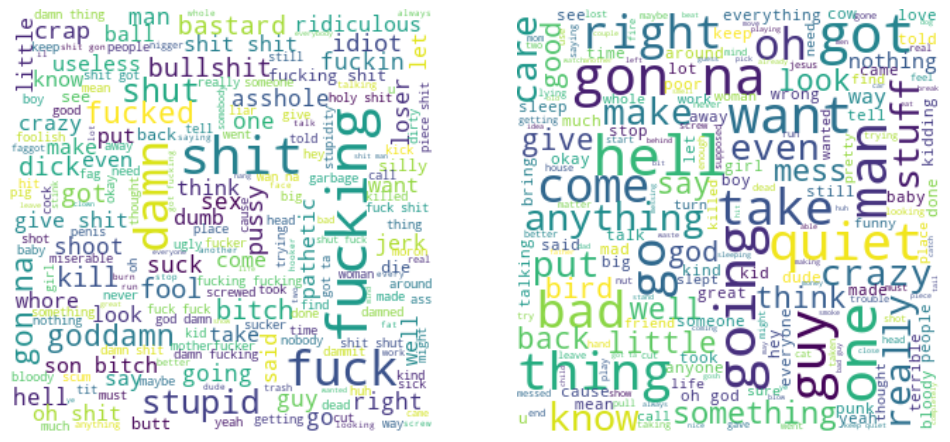

In [128]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(bad_wordcloud, interpolation="bilinear")
ax1.axis("off")
ax2.imshow(good_wordcloud, interpolation="bilinear")
ax2.axis("off")
plt.show()

This is generally good result, since we can see, that our toxic cloud has no more `woman` and `girl` as the heavily weighted toxic words. Of course it is not a scientific approach, but it is good sanity check of our reference data.

In general this approach relates heavilly to the simple dictionary of bad words to replace with good ones. However, this dataset is better, since it provides
1. Several alternatives how they can be replaced
2. Lemmatized approach allows to build solution more robust to word modifications
3. Not simple word2word correspondence, but seq2seq approach, which allows paraphrasing, rather than implace replacements